##1 Data Preparation

In [1]:
import os
import cv2
import random
import numpy as np
import skimage.io as io
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import ImageDataGenerator


/home/auriga/.local/lib/python3.6/site-packages/google/auth/crypt/_cryptography_rsa.py:22: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  import cryptography.exceptions


In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline


In [3]:
def get_annotation(data_dir_path, validation_dir_path):
    return '{}/annotations/instances_{}.json'.format(data_dir_path,validation_dir_path)

data_dir_path = '/mnt/data1/notebooks/coco/'
validation_dir_path = 'val2017'

coco=COCO(get_annotation(data_dir_path, validation_dir_path))


loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


# **#2 Visualization**

**Load random Image**


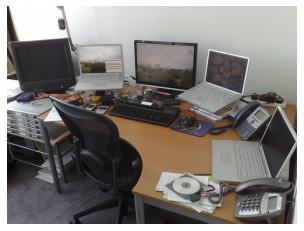

In [4]:
def showImg(x):
    plt.axis('off')
    plt.imshow(x)
    plt.show()
    
def load_random_img(catIds):
    imgIds = coco.getImgIds(catIds=catIds);
    return coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

catIds = coco.getCatIds(catNms=['laptop', 'tv', 'cell phone']);
img = load_random_img(catIds)
I = io.imread('{}/images/{}/{}'.format(data_dir_path,validation_dir_path,img['file_name']))/255.0
showImg(I)


**load and display instance annotations**

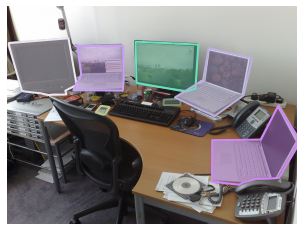

In [5]:
def get_anno_id(catIds):
    return coco.getAnnIds(imgIds=img['id'], catIds=coco.getCatIds(catNms=['laptop', 'tv', 'cell phone']), iscrowd=None)

def load_annotations_of_img(catIds):
    annIds = get_anno_id(catIds)
    return coco.loadAnns(annIds)
    
def show_annotations(catIds):
    coco.showAnns(load_annotations_of_img(catIds))
    
plt.imshow(I);
plt.axis('off')
show_annotations(catIds)


### **Generate a segmentation mask**

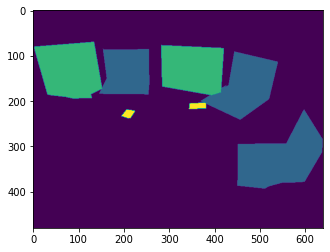

In [6]:
filterClasses = ['laptop', 'tv', 'cell phone']
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
anns = load_annotations_of_img(catIds)

def get_reset_mask():
    return np.zeros((img['height'],img['width']))

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def gen_mask(anns):
    mask = get_reset_mask()
    for i in range(len(anns)):
        className = getClassName(anns[i]['category_id'], cats)
        pixel_value = filterClasses.index(className)+1
        mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
    return mask

mask = gen_mask(anns)
plt.imshow(mask)

### **Generate binary mask**


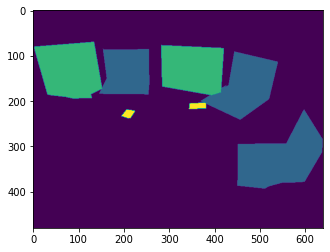

In [7]:
def gen_binary_mask():
    binary_mask = get_reset_mask()
    for i in range(len(anns)):
        binary_mask = np.maximum(coco.annToMask(anns[i]), mask)
    return binary_mask

binary_mask = gen_binary_mask()
plt.imshow(binary_mask)

In [8]:
def id_img(coco, classes):
    images = []
    if classes!=None:
        for className in classes:
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    return catIds, imgIds, images

def remove_repeat(images):
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
    return unique_images
    
def filterDataset(folder, classes=None, mode='train'):    
    annFile = '{}/annotations/instances_{}.json'.format(folder, mode)
    coco = COCO(annFile)
    
    catIds, imgIds, images = id_img(coco, classes)
    
    unique_images = remove_repeat(images)
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [9]:
folder = '/mnt/data1/notebooks/coco/'

classes = ['laptop', 'tv', 'cell phone']
mode = 'val2017'

images, dataset_size, coco = filterDataset(folder, classes,  mode)

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


In [10]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def return_getImage_result(training_image):
    if (len(training_image.shape)==3 and training_image.shape[2]==3):
        return training_image
    else: 
        stacked_img = np.stack((training_image,)*3, axis=-1)
        return stacked_img

def getImage(imageObj, img_dir, imge_shape_ip):
    training_image = io.imread(img_dir + '/' + imageObj['file_name'])/255.0
    training_image = cv2.resize(training_image, imge_shape_ip)
    return return_getImage_result(training_image)

def commomMask(train_mask, imge_shape_ip):   
    return train_mask.reshape(imge_shape_ip[0], imge_shape_ip[1], 1)
    
def maskHelper(imge_shape_ip, anns):
    train_mask = np.zeros(imge_shape_ip)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, imge_shape_ip)
        train_mask = np.maximum(new_mask, train_mask)

    return commomMask(train_mask, imge_shape_ip)  
    
def getAnnotations(imageObj, coco):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    return anns

def getNormalMask(imageObj, classes, coco, catIds, imge_shape_ip):
    anns = getAnnotations(imageObj, coco)
    return maskHelper(imge_shape_ip, anns)

    
def getBinaryMask(imageObj, coco, catIds, imge_shape_ip):
    anns = getAnnotations(imageObj, coco)
    train_mask = np.zeros(imge_shape_ip)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), imge_shape_ip)
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0
        train_mask = np.maximum(new_mask, train_mask)

    return commomMask(train_mask, imge_shape_ip)  

def train_mak_func(mask_type, imageObj, coco, catIds, imge_shape_ip, classes):
    if mask_type=="binary":
        train_mask = getBinaryMask(imageObj, coco, catIds, imge_shape_ip)
    elif mask_type=="normal":
        train_mask = getNormalMask(imageObj, classes, coco, catIds, imge_shape_ip) 
    return train_mask
    
    
def coco_datagenerator(images, classes, coco, folder, 
                      imge_shape_ip=(224,224), batch_size=4, mode='train', mask_type='binary'):
    
    img_dir = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    c = 0
    while(True):
        img = np.zeros((batch_size, imge_shape_ip[0], imge_shape_ip[1], 3)).astype('float')
        mask = np.zeros((batch_size, imge_shape_ip[0], imge_shape_ip[1], 1)).astype('float')

        for i in range(c, c+batch_size):
            imageObj = images[i]
            
            train_img = getImage(imageObj, img_dir, imge_shape_ip)
            
            train_mask = train_mak_func(mask_type, imageObj, coco, catIds, imge_shape_ip, classes)
            
            img[i-c] = train_img
            mask[i-c] = train_mask
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask


In [11]:
batch_size = 4
input_image_size = (224,224)
mask_type = 'normal'

val_gen = coco_datagenerator(images, classes, coco, folder,
                            input_image_size, batch_size, mode, mask_type)

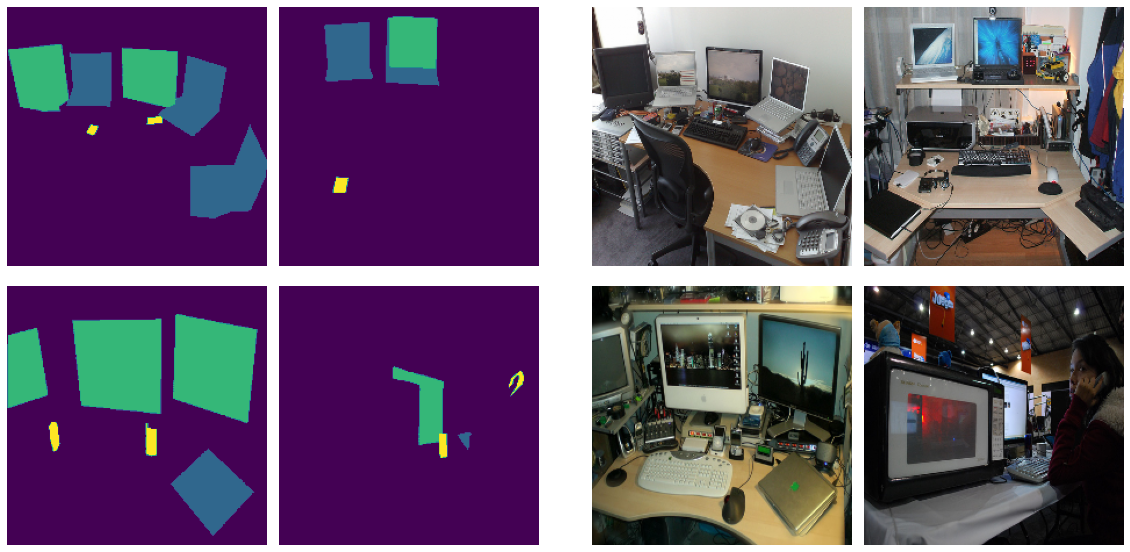

In [12]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

visualizeGenerator(val_gen)

# **#3 Training**

In [14]:
import os
import numpy as np
import skimage.io as io
import cv2
import random
from pycocotools.coco import COCO
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from coco_generator import COCOGenerator


In [15]:
filterClasses = ['laptop', 'tv', 'cell phone']
catIds = coco.getCatIds(catNms=filterClasses)
num_classes = len(catIds)
# print(num_classes)

def get_annotation(data_dir_path, validation_dir_path):
    return '{}/annotations/instances_{}.json'.format(data_dir_path,validation_dir_path)

def set_width_height():
    return 480, 640

def load_coco_model(dp, vp):

    anno_path = get_annotation(dp, vp)
    print(anno_path)
    return COCO(anno_path)


In [16]:
img_height, img_width = set_width_height()

coco = load_coco_model("/mnt/data1/notebooks/coco/images", "train2017")
cocoval = load_coco_model("/mnt/data1/notebooks/coco/images", "val2017")

/mnt/data1/notebooks/coco/images/annotations/instances_train2017.json
loading annotations into memory...
Done (t=10.13s)
creating index...
index created!
/mnt/data1/notebooks/coco/images/annotations/instances_val2017.json
loading annotations into memory...
Done (t=1.57s)
creating index...
index created!


In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = COCOGenerator(
    coco, 
    "/mnt/data1/notebooks/coco/images/train2017",
    transform_generator=train_datagen,
    classes=filterClasses,
    image_size=(img_height, img_width)
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = COCOGenerator(
    cocoval, 
    "/mnt/data1/notebooks/coco/images/val2017",
    transform_generator=val_datagen,
    classes=filterClasses,
    image_size=(img_height, img_width)
)

In [18]:
inputs = Input(shape=(img_height, img_width, 3))
x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

x = layers.Conv2DTranspose(128, 3, strides=(2, 2), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, 3, strides=(2, 2), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=(2, 2), activation="relu", padding="same")(x)
outputs = layers.Conv2D(num_classes, 1, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
history = model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
8/8 [==============================] - 65s 8s/step - loss: 0.1614 - acc: 0.7832 - val_loss: 0.1725 - val_acc: 0.7994
Epoch 2/20
8/8 [==============================] - 65s 8s/step - loss: 0.1530 - acc: 0.7064 - val_loss: 0.1776 - val_acc: 0.5052
Epoch 3/20
8/8 [==============================] - 65s 8s/step - loss: 0.1567 - acc: 0.7480 - val_loss: 0.1632 - val_acc: 0.8280
Epoch 4/20
8/8 [==============================] - 65s 8s/step - loss: 0.1510 - acc: 0.6669 - val_loss: 0.1578 - val_acc: 0.7574
Epoch 5/20
8/8 [==============================] - 65s 8s/step - loss: 0.1504 - acc: 0.5265 - val_loss: 0.1571 - val_acc: 0.7591
Epoch 6/20
8/8 [==============================] - 65s 8s/step - loss: 0.1498 - acc: 0.5211 - val_loss: 0.1587 - val_acc: 0.7507
Epoch 7/20
8/8 [==============================] - 65s 8s/step - loss: 0.1491 - acc: 0.5442 - val_loss: 0.1599 - val_acc: 0.6387
Epoch 8/20
8/8 [==============================] - 65s 8s/step - loss: 0.1445 - acc: 0.5359 - val_loss: 0

In [23]:
import tensorflow as tf
tf.keras.models.save_model(model, "seg_model")

**Accuracy curve**

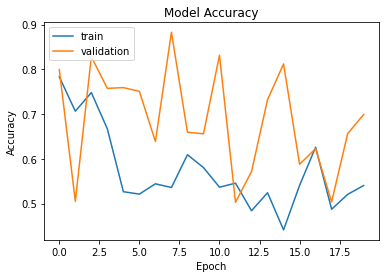

In [31]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "validation"], loc="upper left")
plt.show()